In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import re
from PIL import Image
import webbrowser
import json
import pickle
import sys 
import joblib

sys.path.append('./CC/')

import chemaxon
from chemaxon import *
from compound import Compound
from compound_cacher import CompoundCacher
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem import Draw
from rdkit import Chem

2023-01-19 17:47:51.673 INFO    rdkit: Enabling RDKit 2022.09.3 jupyter extensions


In [2]:
def load_smiles():
    db = pd.read_csv('./data/cache_compounds_20160818.csv',
                     index_col='compound_id')
    db_smiles = db['smiles_pH7'].to_dict()
    return db_smiles

def load_molsig_rad1():
    molecular_signature_r1 = json.load(open('./data/decompose_vector_ac.json'))
    return molecular_signature_r1


def load_molsig_rad2():
    molecular_signature_r2 = json.load(
        open('./data/decompose_vector_ac_r2_py3_indent_modified_manual.json'))
    return molecular_signature_r2


def load_model():
    filename = './model/M12_model_BR.pkl'
    loaded_model = joblib.load(open(filename, 'rb'))
    return loaded_model


def load_compound_cache():
    ccache = CompoundCacher()
    return ccache


In [3]:
def count_substructures(radius, molecule):
    """Helper function for get the information of molecular signature of a
    metabolite. The relaxed signature requires the number of each substructure
    to construct a matrix for each molecule.
    Parameters
    ----------
    radius : int
        the radius is bond-distance that defines how many neighbor atoms should
        be considered in a reaction center.
    molecule : Molecule
        a molecule object create by RDkit (e.g. Chem.MolFromInchi(inchi_code)
        or Chem.MolToSmiles(smiles_code))
    Returns
    -------
    dict
        dictionary of molecular signature for a molecule,
        {smiles: molecular_signature}
    """
    m = molecule
    smi_count = dict()
    atomList = [atom for atom in m.GetAtoms()]

    for i in range(len(atomList)):
        env = Chem.FindAtomEnvironmentOfRadiusN(m, radius, i)
        atoms = set()
        for bidx in env:
            atoms.add(m.GetBondWithIdx(bidx).GetBeginAtomIdx())
            atoms.add(m.GetBondWithIdx(bidx).GetEndAtomIdx())

        # only one atom is in this environment, such as O in H2O
        if len(atoms) == 0:
            atoms = {i}

        smi = Chem.MolFragmentToSmiles(m, atomsToUse=list(atoms),
                                       bondsToUse=env, canonical=True)

        if smi in smi_count:
            smi_count[smi] = smi_count[smi] + 1
        else:
            smi_count[smi] = 1
    return smi_count


In [4]:
def decompse_novel_mets_rad1(novel_smiles, radius=1):
    decompose_vector = dict()

    for cid, smiles_pH7 in novel_smiles.items():
        mol = Chem.MolFromSmiles(smiles_pH7)
        mol = Chem.RemoveHs(mol)
        # Chem.RemoveStereochemistry(mol)
        smi_count = count_substructures(radius, mol)
        decompose_vector[cid] = smi_count
    return decompose_vector


def decompse_novel_mets_rad2(novel_smiles, radius=2):
    decompose_vector = dict()

    for cid, smiles_pH7 in novel_smiles.items():
        mol = Chem.MolFromSmiles(smiles_pH7)
        mol = Chem.RemoveHs(mol)
        # Chem.RemoveStereochemistry(mol)
        smi_count = count_substructures(radius, mol)
        decompose_vector[cid] = smi_count
    return decompose_vector


In [5]:
def parse_reaction_formula_side(s):
    """
        Parses the side formula, e.g. '2 C00001 + C00002 + 3 C00003'
        Ignores stoichiometry.

        Returns:
            The set of CIDs.
    """
    if s.strip() == "null":
        return {}

    compound_bag = {}
    for member in re.split('\s+\+\s+', s):
        tokens = member.split(None, 1)
        if len(tokens) == 0:
            continue
        if len(tokens) == 1:
            amount = 1
            key = member
        else:
            amount = float(tokens[0])
            key = tokens[1]

        compound_bag[key] = compound_bag.get(key, 0) + amount

    return compound_bag


def parse_formula(formula, arrow='<=>', rid=None):
    """
        Parses a two-sided formula such as: 2 C00001 => C00002 + C00003

        Return:
            The set of substrates, products and the direction of the reaction
    """
    tokens = formula.split(arrow)
    if len(tokens) < 2:
        print(('Reaction does not contain the arrow sign (%s): %s'
               % (arrow, formula)))
    if len(tokens) > 2:
        print(('Reaction contains more than one arrow sign (%s): %s'
               % (arrow, formula)))

    left = tokens[0].strip()
    right = tokens[1].strip()

    sparse_reaction = {}
    for cid, count in parse_reaction_formula_side(left).items():
        sparse_reaction[cid] = sparse_reaction.get(cid, 0) - count

    for cid, count in parse_reaction_formula_side(right).items():
        sparse_reaction[cid] = sparse_reaction.get(cid, 0) + count

    return sparse_reaction


In [6]:
def draw_rxn_figure(rxn_dict, db_smiles, novel_smiles):
    # db_smiles = load_smiles()

    left = ''
    right = ''

    for met, stoic in rxn_dict.items():
        if met == "C00080" or met == "C00282":
            continue  # hydogen is not considered
        if stoic > 0:
            if met in db_smiles:
                right = right + db_smiles[met] + '.'
            else:
                right = right + novel_smiles[met] + '.'
        else:
            if met in db_smiles:
                left = left + db_smiles[met] + '.'
            else:
                left = left + novel_smiles[met] + '.'
    smarts = left[:-1] + '>>' + right[:-1]
    # print smarts
    smarts = str(smarts)
    rxn = Reactions.ReactionFromSmarts(smarts, useSmiles=True)
    return Draw.ReactionToImage(rxn)  # , subImgSize=(400, 400))

In [7]:
def get_rule(rxn_dict, molsig1, molsig2, novel_decomposed1, novel_decomposed2):
    if novel_decomposed1 != None:
        for cid in novel_decomposed1:
            molsig1[cid] = novel_decomposed1[cid]
    if novel_decomposed2 != None:
        for cid in novel_decomposed2:
            molsig2[cid] = novel_decomposed2[cid]

    molsigna_df1 = pd.DataFrame.from_dict(molsig1).fillna(0)
    all_mets1 = molsigna_df1.columns.tolist()
    all_mets1.append("C00080")
    all_mets1.append("C00282")

    molsigna_df2 = pd.DataFrame.from_dict(molsig2).fillna(0)
    all_mets2 = molsigna_df2.columns.tolist()
    all_mets2.append("C00080")
    all_mets2.append("C00282")

    moieties_r1 = open('./data/group_names_r1.txt')
    moieties_r2 = open('./data/group_names_r2_py3_modified_manual.txt')
    moie_r1 = moieties_r1.read().splitlines()
    moie_r2 = moieties_r2.read().splitlines()

    molsigna_df1 = molsigna_df1.reindex(moie_r1)
    molsigna_df2 = molsigna_df2.reindex(moie_r2)

    rule_df1 = pd.DataFrame(index=molsigna_df1.index)
    rule_df2 = pd.DataFrame(index=molsigna_df2.index)
    # for rid, value in reaction_dict.items():
    #     # skip the reactions with missing metabolites
    #     mets = value.keys()
    #     flag = False
    #     for met in mets:
    #         if met not in all_mets:
    #             flag = True
    #             break
    #     if flag: continue

    rule_df1['change'] = 0
    for met, stoic in rxn_dict.items():
        if met == "C00080" or met == "C00282":
            continue  # hydogen is zero
        rule_df1['change'] += molsigna_df1[met] * stoic

    rule_df2['change'] = 0
    for met, stoic in rxn_dict.items():
        if met == "C00080" or met == "C00282":
            continue  # hydogen is zero
        rule_df2['change'] += molsigna_df2[met] * stoic

    rule_vec1 = rule_df1.to_numpy().T
    rule_vec2 = rule_df2.to_numpy().T

    m1, n1 = rule_vec1.shape
    m2, n2 = rule_vec2.shape

    zeros1 = np.zeros((m1, 44))
    zeros2 = np.zeros((m2, 44))
    X1 = np.concatenate((rule_vec1, zeros1), 1)
    X2 = np.concatenate((rule_vec2, zeros2), 1)

    rule_comb = np.concatenate((X1, X2), 1)

    # rule_df_final = {}
    # rule_df_final['rad1'] = rule_df1
    # rule_df_final['rad2'] = rule_df2
    return rule_comb, rule_df1, rule_df2

In [8]:
def get_ddG0(rxn_dict, pH, I, novel_mets):
    ccache = CompoundCacher()
    # ddG0 = get_transform_ddG0(rxn_dict, ccache, pH, I, T)
    T = 298.15
    ddG0_forward = 0
    for compound_id, coeff in rxn_dict.items():
        if novel_mets != None and compound_id in novel_mets:
            comp = novel_mets[compound_id]
        else:
            comp = ccache.get_compound(compound_id)
        ddG0_forward += coeff * comp.transform_pH7(pH, I, T)

    return ddG0_forward

In [9]:
def get_dG0(rxn_dict, rid, pH, I, loaded_model, molsig_r1, molsig_r2, novel_decomposed_r1, novel_decomposed_r2, novel_mets):

    # rule_df = get_rxn_rule(rid)
    rule_comb, rule_df1, rule_df2 = get_rule(
        rxn_dict, molsig_r1, molsig_r2, novel_decomposed_r1, novel_decomposed_r2)

    X = rule_comb

    ymean, ystd = loaded_model.predict(X, return_std=True)

    result = {}
    # result['dG0'] = ymean[0] + get_ddG0(rxn_dict, pH, I)
    # result['standard deviation'] = ystd[0]

    # result_df = pd.DataFrame([result])
    # result_df.style.hide_index()
    # return result_df
    return ymean[0] + get_ddG0(rxn_dict, pH, I, novel_mets), ystd[0], rule_df1, rule_df2
    # return ymean[0],ystd[0]


In [10]:
def parse_novel_molecule(add_info):
    result = {}
    for cid, InChI in add_info.items():
        c = Compound.from_inchi('Test', cid, InChI)
        result[cid] = c
    return result


def parse_novel_smiles(result):
    novel_smiles = {}
    for cid, c in result.items():
        smiles = c.smiles_pH7
        novel_smiles[cid] = smiles
    return novel_smiles


In [12]:
db_smiles = load_smiles()
molsig_r1 = load_molsig_rad1()
molsig_r2 = load_molsig_rad2()

# the model_gen.py must first be executed
loaded_model = load_model()
ccache = load_compound_cache()

## Estimating dG for reaction with novel metabolite

In [24]:
rxn_str = 'C01745 + C00004 --> N00001 + C00003 + C00001'

In [25]:
rxn_str

'C01745 + C00004 --> N00001 + C00003 + C00001'

In [15]:
add_info = {"N00001":"InChI=1S/C14H12O/c15-14-8-4-7-13(11-14)10-9-12-5-2-1-3-6-12/h1-11,15H/b10-9+"}

In [16]:
add_info['N00001']

'InChI=1S/C14H12O/c15-14-8-4-7-13(11-14)10-9-12-5-2-1-3-6-12/h1-11,15H/b10-9+'

In [17]:
pH = 7 # any number between 0-14 
I = 0.1    #min_value=0.0, max_value=0.5)

In [18]:
try:
    novel_mets = parse_novel_molecule(add_info)
    novel_smiles = parse_novel_smiles(novel_mets)
    novel_decomposed_r1 = decompse_novel_mets_rad1(novel_smiles)
    novel_decomposed_r2 = decompse_novel_mets_rad2(novel_smiles)

except Exception as e:
    novel_mets = None
    novel_smiles = None
    novel_decomposed_r1 = None
    novel_decomposed_r2 = None

print(novel_smiles)


2023-01-19 17:58:55.637 WARNING root: chemaxon failed to find pKas for this molecule: InChI=1S/C14H12O/c15-14-8-4-7-13(11-14)10-9-12-5-2-1-3-6-12/h1-11,15H/b10-9+


{'N00001': 'c1ccc(cc1)/C=C/c1cccc(c1)O'}


In [31]:
# dir(novel_mets['N00001'])
print((novel_mets["N00001"].smiles_pH7))

c1ccc(cc1)/C=C/c1cccc(c1)O


In [19]:
rxn_dict = parse_formula(rxn_str)

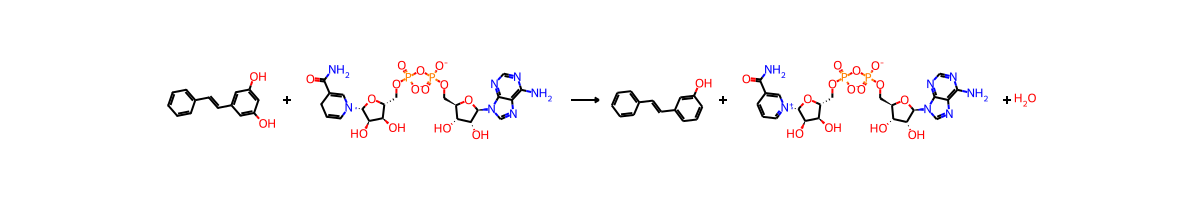

In [20]:
draw_rxn_figure(rxn_dict, db_smiles,novel_smiles)

In [21]:
mu, std, rule_df1, rule_df2 = get_dG0(rxn_dict, 'R00801', pH, I, loaded_model, molsig_r1, molsig_r2, novel_decomposed_r1, novel_decomposed_r2, novel_mets)

print("dG = %.2f ± %.2f kJ/mol" % (mu, std))

dG = -121.74 ± 97.58 kJ/mol


## Bulk estimation of dG for a list of KEGG reactions

In [22]:
KEGG_rxn_list = {"R00010" : "C01083 + C00001 <=> 2 C00031",
                 "R00303" : "C00092 + C00001 <=> C00031 + C00009",
                 "R00304" : "C00103 + C00001 <=> C00031 + C00009",
                 "R07294" : "C15524 + C00001 <=> C02137 + C00010",
                 "R01252" : "C00148 + C00026 + C00007 <=> C01157 + C00042 + C00011",
                 "R00406" : "C00091 + C00149 <=> C00042 + C04348"
                }

In [23]:
pH = 7 # any number between 0-14 
I = 0.1    #min_value=0.0, max_value=0.5)

for keys in KEGG_rxn_list:
    kegg_rxn_string = KEGG_rxn_list[keys]
    kegg_rxn_dict = parse_formula(kegg_rxn_string)
    mu, std, rule_df1, rule_df2 = get_dG0(kegg_rxn_dict, keys, pH, I, loaded_model, molsig_r1, molsig_r2, [], [], [])
    print(keys)
    print(kegg_rxn_string)
    print("dG = %.2f ± %.2f kJ/mol" % (mu, std))

R00010
C01083 + C00001 <=> 2 C00031
dG = -12.45 ± 3.49 kJ/mol
R00303
C00092 + C00001 <=> C00031 + C00009
dG = -12.40 ± 3.30 kJ/mol
R00304
C00103 + C00001 <=> C00031 + C00009
dG = -18.78 ± 3.37 kJ/mol
R07294
C15524 + C00001 <=> C02137 + C00010
dG = -14.46 ± 31.84 kJ/mol
R01252
C00148 + C00026 + C00007 <=> C01157 + C00042 + C00011
dG = -427.04 ± 50.51 kJ/mol
R00406
C00091 + C00149 <=> C00042 + C04348
dG = -3.27 ± 4.37 kJ/mol
